
# 🧩 From One‑Hot to Word2Vec: Representing Meaning in Vectors

**Course:** Introduction to Text Analysis  
**Topic:** Word representations (sparse → dense)  
**Instructions:** Run top‑to‑bottom. Keep runtime low (use provided subsets).

**Learning goals**
1. Build and inspect **one‑hot** and **TF‑IDF** representations.
2. Train **Word2Vec** models (CBOW & Skip‑gram) and explore similarity.
3. **Visualize** similarities and clusters with heatmaps, PCA, and **t‑SNE**.


## 0) Setup

In [1]:

# If needed, install locally:
# !pip install nltk gensim scikit-learn matplotlib

import random, os, math, collections
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import reuters
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from gensim.models import Word2Vec

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED)

# NLTK data (first run may download)
nltk.download('reuters', quiet=True)
nltk.download('punkt', quiet=True)

print("Setup complete.")


Setup complete.



## 1) Load and preprocess a small Reuters subset


In [2]:

N_DOCS = 1200  # adjust if your machine permits
file_ids = reuters.fileids()[:N_DOCS]

raw_docs = [reuters.raw(fid) for fid in file_ids]
tokens_per_doc = [word_tokenize(doc.lower()) for doc in raw_docs]

def normalize(tokens):
    return [t for t in tokens if t.isalpha() and len(t) > 2]

norm_tokens_per_doc = [normalize(ts) for ts in tokens_per_doc]
print(f"Documents: {len(norm_tokens_per_doc)}")


Documents: 1200



## 2) One‑hot encoding (word level)


In [3]:

from collections import Counter

K = 500  # top-K frequent words
all_tokens = [t for doc in norm_tokens_per_doc for t in doc]
freqs = Counter(all_tokens)
vocab = [w for w, _ in freqs.most_common(K)]
word_to_idx = {w:i for i, w in enumerate(vocab)}

def one_hot(word, vocab_index):
    vec = np.zeros(len(vocab_index), dtype=np.float32)
    if word in vocab_index:
        vec[vocab_index[word]] = 1.0
    return vec

def cos_sim(a, b, eps=1e-8):
    na, nb = np.linalg.norm(a), np.linalg.norm(b)
    if na < eps or nb < eps:
        return 0.0
    return float(np.dot(a, b) / (na * nb))

w1, w2 = 'oil', 'bank'
v1, v2 = one_hot(w1, word_to_idx), one_hot(w2, word_to_idx)
print(f"Cosine(one-hot('{w1}'), one-hot('{w2}')) = {cos_sim(v1, v2):.3f}")
print("Note: unless the words are identical, one‑hot vectors are orthogonal → similarity ≈ 0.")


Cosine(one-hot('oil'), one-hot('bank')) = 0.000
Note: unless the words are identical, one‑hot vectors are orthogonal → similarity ≈ 0.



### ✍️ Short answer
Why are one‑hot vectors **orthogonal** for different words, and what does that imply for measuring semantic similarity?



## 3) TF–IDF (document level, sparse)


In [4]:

docs_for_vectorizer = [" ".join(doc) for doc in norm_tokens_per_doc]

vectorizer = TfidfVectorizer(max_features=3000, min_df=5)
X_tfidf = vectorizer.fit_transform(docs_for_vectorizer)

print("TF-IDF shape:", X_tfidf.shape)
sparsity = 1.0 - (X_tfidf.nnz / (X_tfidf.shape[0] * X_tfidf.shape[1]))
print(f"Sparsity ≈ {sparsity:.3f}")


TF-IDF shape: (1200, 2137)
Sparsity ≈ 0.979



### Visualize: TF‑IDF document similarity heatmap


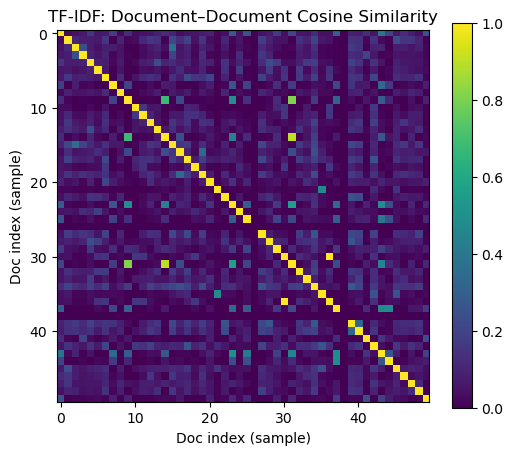

In [5]:

idx = np.random.choice(X_tfidf.shape[0], size=min(50, X_tfidf.shape[0]), replace=False)
S = cosine_similarity(X_tfidf[idx], X_tfidf[idx])

plt.figure(figsize=(6,5))
plt.imshow(S)
plt.title("TF-IDF: Document–Document Cosine Similarity")
plt.xlabel("Doc index (sample)"); plt.ylabel("Doc index (sample)")
plt.colorbar()
plt.show()



## 4) Word2Vec models (CBOW & Skip‑gram)
We will train **two** models with identical hyperparameters except for `sg`.


In [6]:

# CBOW (sg=0) and Skip-gram (sg=1)
w2v_cbow = Word2Vec(
    sentences=norm_tokens_per_doc,
    vector_size=50, window=5, min_count=5, workers=1,
    sg=0, seed=SEED, epochs=10
)
w2v_sg = Word2Vec(
    sentences=norm_tokens_per_doc,
    vector_size=50, window=5, min_count=5, workers=1,
    sg=1, seed=SEED, epochs=10
)

print("CBOW vocab size:", len(w2v_cbow.wv))
print("Skip-gram vocab size:", len(w2v_sg.wv))

# Keep one reference model for generic cells below
w2v = w2v_cbow


CBOW vocab size: 2711
Skip-gram vocab size: 2711



### Compare nearest neighbors (CBOW vs Skip‑gram)


In [7]:

def compare_neighbors(words, topn=5):
    for w in words:
        print(f"\n=== '{w}' ===")
        if w in w2v_cbow.wv:
            print("CBOW:")
            for ww, s in w2v_cbow.wv.most_similar(w, topn=topn):
                print(f"  {ww:15s} {s:.3f}")
        else:
            print("CBOW: OOV")

        if w in w2v_sg.wv:
            print("Skip-gram:")
            for ww, s in w2v_sg.wv.most_similar(w, topn=topn):
                print(f"  {ww:15s} {s:.3f}")
        else:
            print("Skip-gram: OOV")

probe_words = ["oil", "opec", "bank", "money", "trade", "wheat"]
compare_neighbors(probe_words, topn=5)



=== 'oil' ===
CBOW:
  gas             0.818
  crude           0.806
  china           0.769
  edible          0.762
  sunflowerseed   0.762
Skip-gram:
  crude           0.805
  gas             0.777
  natural         0.757
  supplies        0.730
  palm            0.727

=== 'opec' ===
CBOW:
  such            0.989
  quotas          0.987
  pressure        0.985
  electronic      0.982
  diplomats       0.982
Skip-gram:
  pricing         0.867
  kuwait          0.866
  cheaper         0.856
  credibility     0.851
  lichtblau       0.818

=== 'bank' ===
CBOW:
  england         0.822
  central         0.779
  savings         0.751
  federal         0.731
  seven           0.706
Skip-gram:
  england         0.752
  dollars         0.707
  opening         0.693
  afternoon       0.689
  central         0.686

=== 'money' ===
CBOW:
  drop            0.915
  yen             0.911
  currency        0.910
  because         0.908
  dollar          0.906
Skip-gram:
  liquidity       0.828
  as


### Visualize: PCA projections for selected semantic groups (CBOW & Skip‑gram)


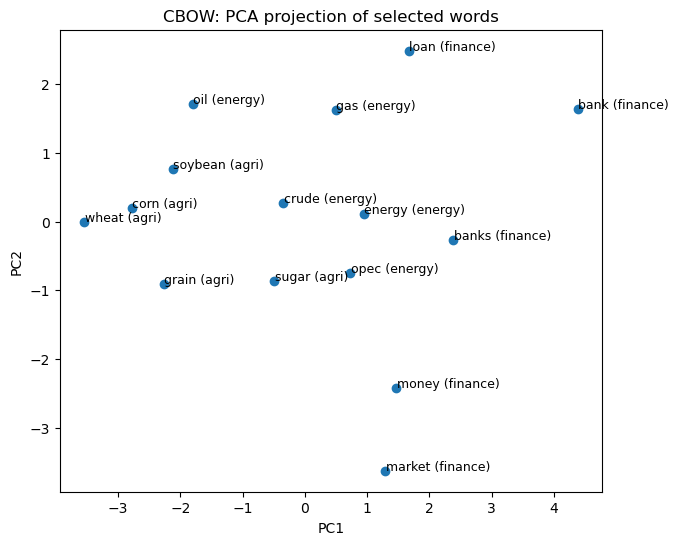

In [8]:

groups = {
    "energy": ["oil", "opec", "gas", "energy", "crude"],
    "finance": ["bank", "banks", "money", "loan", "market"],
    "agri": ["wheat", "corn", "grain", "soybean", "sugar"],
}

# CBOW
labels_cbow, vecs_cbow = [], []
for gname, words in groups.items():
    for w in words:
        if w in w2v_cbow.wv:
            labels_cbow.append(f"{w} ({gname})")
            vecs_cbow.append(w2v_cbow.wv[w])

vecs_cbow = np.array(vecs_cbow)
if vecs_cbow.shape[0] >= 2:
    pca = PCA(n_components=2, random_state=SEED)
    coords = pca.fit_transform(vecs_cbow)

    plt.figure(figsize=(7,6))
    plt.scatter(coords[:,0], coords[:,1])
    for (x, y), label in zip(coords, labels_cbow):
        plt.text(x+0.01, y+0.01, label, fontsize=9)
    plt.title("CBOW: PCA projection of selected words")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.show()
else:
    print("Not enough in-vocab words for CBOW PCA plot.")


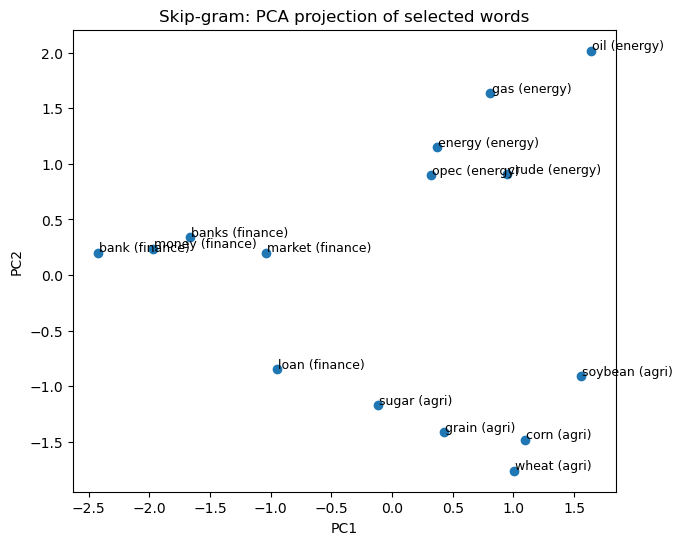

In [9]:

# Skip-gram
labels_sg, vecs_sg = [], []
for gname, words in groups.items():
    for w in words:
        if w in w2v_sg.wv:
            labels_sg.append(f"{w} ({gname})")
            vecs_sg.append(w2v_sg.wv[w])

vecs_sg = np.array(vecs_sg)
if vecs_sg.shape[0] >= 2:
    pca = PCA(n_components=2, random_state=SEED)
    coords = pca.fit_transform(vecs_sg)

    plt.figure(figsize=(7,6))
    plt.scatter(coords[:,0], coords[:,1])
    for (x, y), label in zip(coords, labels_sg):
        plt.text(x+0.01, y+0.01, label, fontsize=9)
    plt.title("Skip-gram: PCA projection of selected words")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.show()
else:
    print("Not enough in-vocab words for Skip-gram PCA plot.")



### Visualize: t‑SNE projection (Word2Vec)


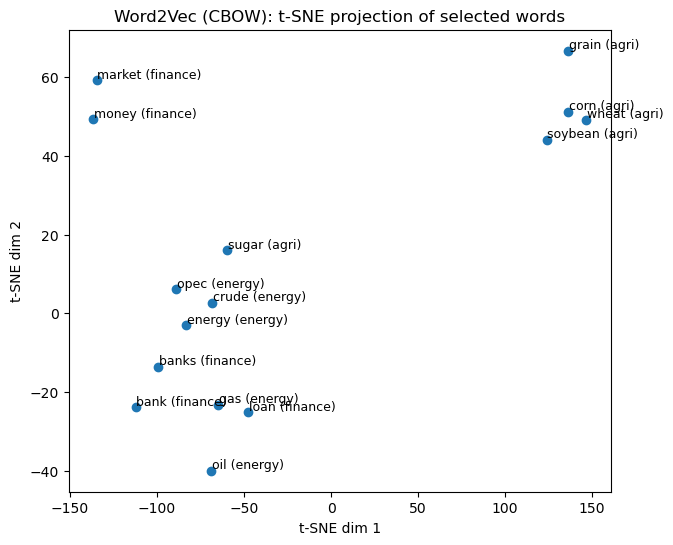

In [11]:

# Build labels/vecs from CBOW model for t-SNE
labels, vecs = [], []
for gname, words in groups.items():
    for w in words:
        if w in w2v.wv:
            labels.append(f"{w} ({gname})")
            vecs.append(w2v.wv[w])

vecs = np.array(vecs)
if vecs.shape[0] >= 2:
    tsne = TSNE(n_components=2, perplexity=2, learning_rate='auto', init='random', random_state=SEED, n_iter=1000)
    coords_tsne = tsne.fit_transform(vecs)

    plt.figure(figsize=(7,6))
    plt.scatter(coords_tsne[:,0], coords_tsne[:,1])
    for (x, y), label in zip(coords_tsne, labels):
        plt.text(x+0.5, y+0.5, label, fontsize=9)
    plt.title("Word2Vec (CBOW): t-SNE projection of selected words")
    plt.xlabel("t-SNE dim 1"); plt.ylabel("t-SNE dim 2")
    plt.show()
else:
    print("Not enough in-vocab words for t-SNE.")



### (Optional) Word analogies (CBOW vs Skip‑gram)


In [12]:

def try_analogy(model, a, b, c, topn=5):
    if all(w in model.wv for w in [a, b, c]):
        print(f"{a} - {b} + {c} ≈ ?")
        print(model.wv.most_similar(positive=[a, c], negative=[b], topn=topn))
    else:
        print("Some words are OOV for this model.")

print("CBOW analogy:")
try_analogy(w2v_cbow, "bank", "money", "loan", topn=5)

print("\nSkip-gram analogy:")
try_analogy(w2v_sg, "bank", "money", "loan", topn=5)


CBOW analogy:
bank - money + loan ≈ ?
[('qtr', 0.8570876121520996), ('searle', 0.8099834322929382), ('national', 0.8090721964836121), ('shr', 0.7996731400489807), ('bowater', 0.7944625020027161)]

Skip-gram analogy:
bank - money + loan ≈ ?
[('savings', 0.6447624564170837), ('association', 0.6259415149688721), ('westminster', 0.6125415563583374), ('california', 0.5900944471359253), ('mortgage', 0.579775869846344)]



## 5) Compare representations
**Task:** In 3–5 bullet points, compare **one‑hot**, **TF‑IDF**, and **Word2Vec** in terms of:
- dimensionality and sparsity  
- ability to capture **semantic similarity**  
- typical use‑cases

Write your answer below.



**Your answer:**

- ...
- ...
- ...



### (Optional stretch) Document embeddings from Word2Vec


Mean-embedded docs shape: (1200, 50)


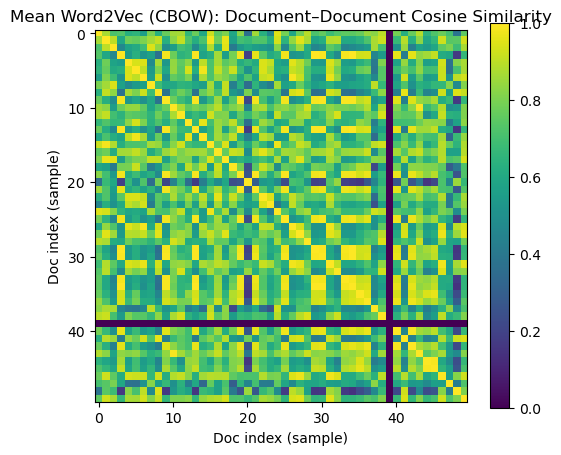

In [13]:

def doc_mean_vector(tokens, model):
    vs = [model.wv[w] for w in tokens if w in model.wv]
    return np.mean(vs, axis=0) if vs else np.zeros(model.vector_size, dtype=np.float32)

doc_vecs = np.vstack([doc_mean_vector(doc, w2v_cbow) for doc in norm_tokens_per_doc])
print("Mean-embedded docs shape:", doc_vecs.shape)

idx2 = np.random.choice(len(doc_vecs), size=min(50, len(doc_vecs)), replace=False)
S_w2v = cosine_similarity(doc_vecs[idx2], doc_vecs[idx2])

plt.figure(figsize=(6,5))
plt.imshow(S_w2v)
plt.title("Mean Word2Vec (CBOW): Document–Document Cosine Similarity")
plt.xlabel("Doc index (sample)"); plt.ylabel("Doc index (sample)")
plt.colorbar()
plt.show()
